In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px

from sklearn.cluster import KMeans
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')


# Load the edp_survey_aircon dataset (replace with the correct path)
edp_survey_aircon = pd.read_csv(os.path.join(base_directory, "survey/edp_survey_aircon.csv"))

# Assuming 'site_id' and 'climate_zone' columns exist in edp_survey_aircon
climate_zone_mapping = edp_survey_aircon.set_index('edp_site_id')['climate_zone'].to_dict()



In [5]:


# Directory containing the household CSV files
data_dir = cleaned_data_directory

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

# Initialize an empty DataFrame with the date range as the index
combined_df = pd.DataFrame(index=date_range)

# Iterate through each CSV file in the directory
for filename in os.listdir(data_dir):
    if filename.endswith("_profile.csv"):
        file_path = os.path.join(data_dir, filename)
        
        # Load the household CSV file
        df = pd.read_csv(file_path)
        
        # Convert the 'TS' column to datetime
        df['TS'] = pd.to_datetime(df['TS'])
        
        # Set 'TS' as the index and extract 'Air_Conditioner_Load'
        df = df.set_index('TS')['Air_Conditioner_Load']
        
        # Extract site ID from the filename (assuming the filename format is 'siteid_profile.csv')
        site_id = filename.split('_')[0]
        
        # Merge the data with the combined DataFrame based on timestamps
        combined_df[site_id] = df.reindex(combined_df.index)



# Save the combined DataFrame to a CSV file (optional)
# combined_df.to_csv('combined_air_conditioner_load_profiles.csv')
combined_df = combined_df.reset_index()

combined_df = combined_df.rename(columns={'index': 'Timestamp'})
ids_to_remove = [
    'S0024', 'S0159', 'S0318', 'S0444', 'S0470',
    'W0082', 'W0120', 'W0162', 'W0175', 'W0224',
    'W0241', 'W0243', 'W0315', 'W0324', 'W0330', 'W0310', 'W0335', "W0336"
    ,"W0213", "S0261"
]

combined_df = combined_df.drop(columns=ids_to_remove, errors = 'ignore')

C:\Users\CEEM04\AppData\Local\Temp\ipykernel_22668\1731624602.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\CEEM04\AppData\Local\Temp\ipykernel_22668\1731624602.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\CEEM04\AppData\Local\Temp\ipykernel_22668\1731624602.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

In [7]:
# Normalize the data using RobustScaler
def normalize_data(df):
    # Create a copy of the data excluding the 'Timestamp' column
    consumption_data = df.drop(columns=['Timestamp'])

    # Apply RobustScaler to the data
    scaler = pr.PowerTransformer()
    scaled_data = scaler.fit_transform(consumption_data)

    # minmax_scaler = pr.MinMaxScaler(feature_range=(0, 1))
    # scaled_data = minmax_scaler.fit_transform(scaled_data)
    
    # Create a DataFrame for the normalized data, retaining the original column names
    normalized_df = pd.DataFrame(scaled_data, columns=consumption_data.columns)

    # Add the 'Timestamp' column back to the normalized DataFrame
    normalized_df['Timestamp'] = df['Timestamp'].reset_index(drop=True)
    
    return normalized_df


def visualize (df):
    plt.figure(num=2, figsize=(15,8))
    plt.plot(df, color='c', alpha=0.1, linewidth='3')
    plt.plot(df.mean(axis=1),color='k', alpha=1, linewidth='4')
    plt.title(df.name, fontsize = 20)
    plt.ylabel('Normalized Average Hourly Consumption', fontsize = 15)
    plt.xticks(df.index)
    plt.xlabel('Time of the Day', fontsize = 15)
    l = mpatches.Patch(color='black', label='Mean Normalized Average Hourly Consumption')
    plt.legend(handles=[l])
    plt.show()


# Normalize the combined data
normalized_combined_df = normalize_data(combined_df)

# Create a 'Month' column for seasonal filtering
normalized_combined_df['Month'] = normalized_combined_df["Timestamp"].dt.month

# Create seasonal DataFrames
summer = (normalized_combined_df.Month >= 6) & (normalized_combined_df.Month <= 8)  # June to August
Summer_df = normalized_combined_df[summer].reset_index(drop=True)
Summer_df = Summer_df.drop('Month', axis=1)

fall = (normalized_combined_df.Month >= 9) & (normalized_combined_df.Month <= 11)  # September to November
Fall_df = normalized_combined_df[fall].reset_index(drop=True)
Fall_df = Fall_df.drop('Month', axis=1)

winter = (normalized_combined_df.Month <= 2) | (normalized_combined_df.Month == 12)  # January, February, December
Winter_df = normalized_combined_df[winter].reset_index(drop=True)
Winter_df = Winter_df.drop('Month', axis=1)

spring = (normalized_combined_df.Month >= 3) & (normalized_combined_df.Month <= 5)  # March to May
Spring_df = normalized_combined_df[spring].reset_index(drop=True)
Spring_df = Spring_df.drop('Month', axis=1)

# # Add a 'Weekday' column to each season DataFrame
# for df in [Summer_df, Fall_df, Winter_df, Spring_df]:
#     df['Weekday'] = df['Timestamp'].dt.weekday

# # Split each season DataFrame into weekdays and weekends
# def split_season_by_day_type(season_df, day_type):
#     # Add a 'Day_Type' column: 'WD' for weekdays and 'WE' for weekends
#     season_df['Day_Type'] = season_df['Weekday'].apply(lambda x: 'WD' if x < 5 else 'WE')
#     season_df = season_df[season_df['Day_Type'] == day_type]
#     season_df = season_df.drop(['Weekday', 'Day_Type'], axis=1)
#     return season_df

# # Example usage for each season DataFrame:
# # Get weekdays data for summer
# summer_weekdays = split_season_by_day_type(Summer_df, 'WD')
# # Get weekends data for summer
# summer_weekends = split_season_by_day_type(Summer_df, 'WE')
# # Similarly for other seasons:
# fall_weekdays = split_season_by_day_type(Fall_df, 'WD')
# fall_weekends = split_season_by_day_type(Fall_df, 'WE')
# winter_weekdays = split_season_by_day_type(Winter_df, 'WD')
# winter_weekends = split_season_by_day_type(Winter_df, 'WE')
# spring_weekdays = split_season_by_day_type(Spring_df, 'WD')
# spring_weekends = split_season_by_day_type(Spring_df, 'WE')

# Now you can process each of these DataFrames further, if needed
def process(df):
    df.name = '%s' % df
    # Changing the resolution of the data to '1 hour'.
    df = df.set_index('Timestamp', drop=True, append=False, inplace=False, verify_integrity=False)

    # Adding a new 'Hour' column to get the hour and minutes of all corresponding timestamps
    df['Hour'] = pd.to_datetime(df.index, format='%H:%M').time
    df['Hour'] = df.Hour.apply(lambda x: x.strftime('%H:%M'))
    df['Date'] = df.index.date

    # Grouping the DataFrame by hour to get 24 hours of the day as index (0 to 23)
    Hourly = df.groupby(['Hour']).mean()

    return Hourly 

summer = process(Summer_df)
fall = process(Fall_df)
winter = process(Winter_df)
spring = process(Spring_df)


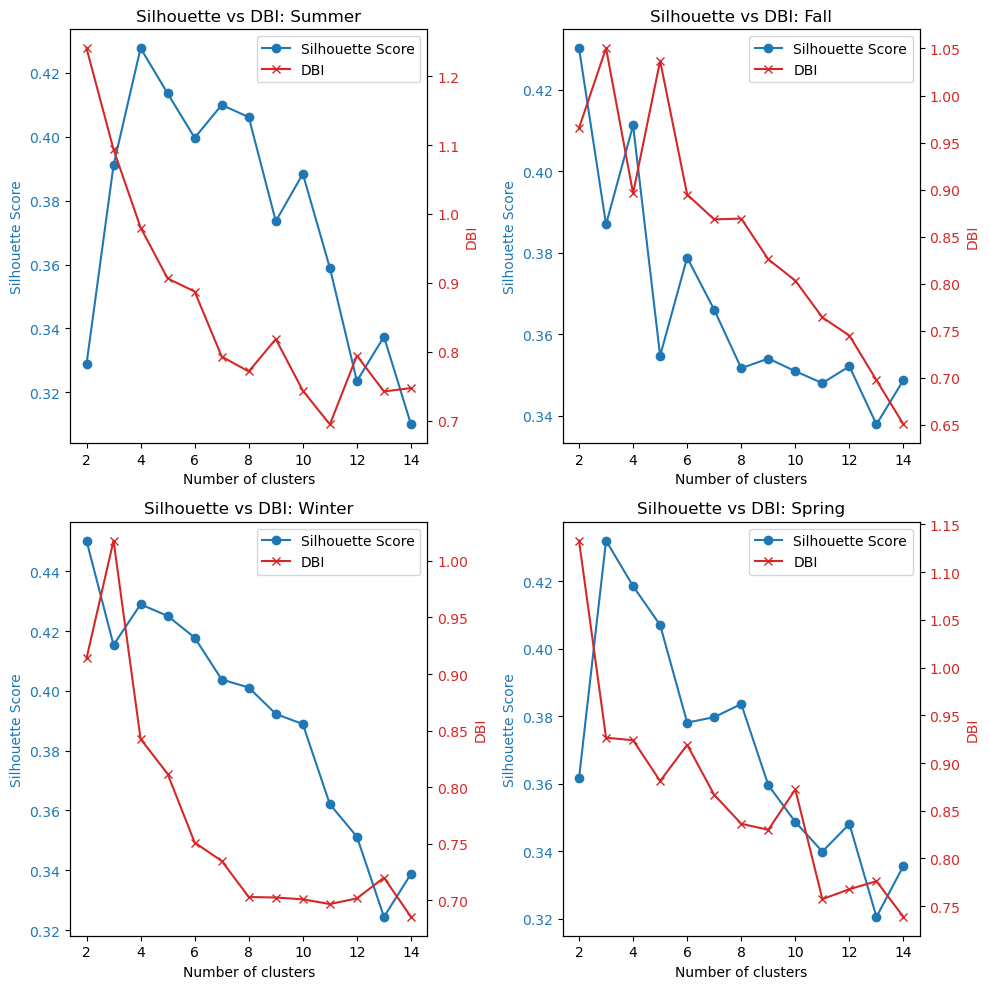

In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Function to calculate both Silhouette and DBI scores
def kmeans_sil_dbi(num_clusters_range, x_vals):
    sil_scores = []
    dbi_scores = []
    
    for k in num_clusters_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x_vals)
        
        # Silhouette score (only valid for k > 1)
        if k > 1:
            sil_scores.append(silhouette_score(x_vals, labels))
        else:
            sil_scores.append(None)
        
        # Davies-Bouldin Index (only valid for k > 1)
        if k > 1:
            dbi_scores.append(davies_bouldin_score(x_vals, labels))
        else:
            dbi_scores.append(None)
    
    return sil_scores, dbi_scores

# Range of clusters to evaluate
num_clusters_range = range(2, 15)

# List of datasets for different season + weekday/weekend combinations
season_combinations = [
    ('Summer', summer),
    ('Fall', fall),
    ('Winter', winter),
    ('Spring', spring)
]

# Create a 4x2 grid for the subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through each season + day combination
for idx, (season, df) in enumerate(season_combinations):
    # Calculate silhouette and DBI for the current dataset
    sil_scores, dbi_scores = kmeans_sil_dbi(num_clusters_range, df)
    
    # Create a dual-axis plot for both Silhouette and DBI
    ax1 = axes[idx]
    
    # Plot silhouette score on the left y-axis
    color1 = 'tab:blue'
    ax1.plot(num_clusters_range, sil_scores, color=color1, marker="o", label="Silhouette Score")
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_title(f'Silhouette vs DBI: {season}')
    
    # Create a second y-axis for DBI
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(num_clusters_range, dbi_scores, color=color2, marker="x", label="DBI")
    ax2.set_ylabel('DBI', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Combine both legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
